In [79]:
import json
from sqlalchemy import create_engine, func

def _create_engine(conf_file, key):
    with open(conf_file, 'r') as f:
        conf = json.load(f)
        return create_engine(conf['local']['uri'])
engine = _create_engine('db-conf.json', 'dp.kamko.dev')

In [10]:
import pandas as pd
pd.sql = lambda sql: pd.read_sql(sql, con=engine)

def display_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)

%matplotlib inline

In [117]:
from furl import furl
import seaborn as sns
import matplotlib.pyplot as plt

Najnovsie info o facebook engagemente pre sledovane URL

In [91]:
df = pd.sql('''
SELECT sq.*, s.url as source
FROM (
         SELECT afb.*, row_number() over (partition by url order by sync_date desc) rn
         FROM article_fb_engagement afb) sq
JOIN article a on sq.url = a.url
JOIN source s on a.source_id = s.id
WHERE sq.rn = 1;
''')
df['popularity'] = df['reaction_count'] + df['comment_count'] + df['share_count'] + df['comment_plugin_count']

In [92]:
display_all(df.groupby('source')['popularity'].describe().sort_values('count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
http://naturalnews.com,20751.0,1232.885162,41505.391697,0.0,19.00,88.0,250.00,5197586.0
http://naturalnewsblogs.com,17756.0,86.888263,2294.673255,0.0,0.00,0.0,1.00,203855.0
http://neurosciencenews.com,13119.0,269.900145,4009.884219,0.0,0.00,0.0,44.00,294411.0
http://statnews.com,12224.0,211.219404,1870.957699,0.0,0.00,0.0,23.00,82773.0
http://hsionline.com,8164.0,0.818716,12.152769,0.0,0.00,0.0,0.00,726.0
http://naturalsociety.com,7348.0,10.238024,598.717047,0.0,0.00,0.0,0.00,49319.0
http://healthnutnews.com,7216.0,1661.907705,23567.982468,0.0,4.00,178.0,740.25,1810343.0
http://healthimpactnews.com,6258.0,354.000320,10897.834244,0.0,0.00,0.0,8.00,841807.0
http://infowars.com,6021.0,52.944860,380.210064,0.0,0.00,0.0,8.00,16902.0


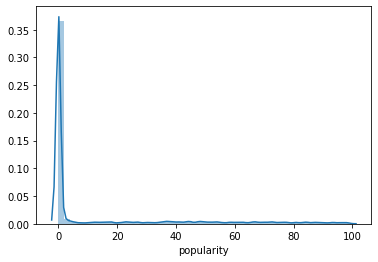

In [148]:
def show_source_popularity_histogram(df, source, quantile):
    xdf = df[df['source'] == source]
    xdf = xdf[xdf['popularity'] < xdf['popularity'].quantile(quantile)]
    plot = sns.distplot(xdf['popularity'])
    plt.show()
    return plot

sources_sorted = df.groupby('source')['popularity'].describe().sort_values('count', ascending=False).index
# for i in sources_sorted[:25]:
#     show_source_popularity_histogram(df, i, 0.9)

show_source_popularity_histogram(df, 'http://zemavek.sk', 0.75)

In [80]:
monitored_articles = pd.sql('''
SELECT afe.*, row_number() over (PARTITION BY url ORDER BY sync_date)
FROM article_fb_engagement afe
WHERE url in (SELECT url
              FROM article
                       JOIN monitored_article ma on article.id = ma.article_id)
ORDER BY url, sync_date;
''')

In [81]:
monitored_articles['popularity'] = monitored_articles['reaction_count'] + monitored_articles['comment_count'] + monitored_articles['share_count'] + monitored_articles['comment_plugin_count']

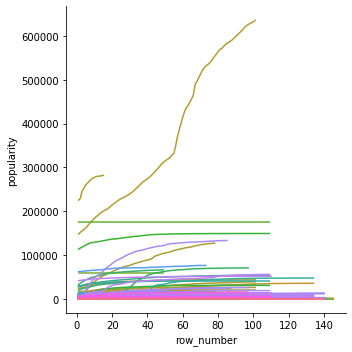

In [82]:
sns.relplot(data=monitored_articles,
            x='row_number', y='popularity',
            hue='url', kind='line',
            legend=False)

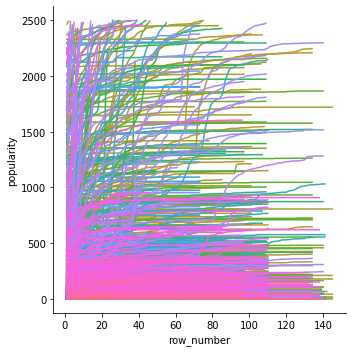

In [83]:
sns.relplot(data=monitored_articles[monitored_articles['popularity'] < 2500],
            x='row_number', y='popularity',
            hue='url', kind='line',
            legend=False)

In [84]:
natural_news = pd.sql('''
SELECT afe.*, row_number() over (PARTITION BY url ORDER BY sync_date)
FROM article_fb_engagement afe
WHERE url in (SELECT url
              FROM article
                       JOIN monitored_article ma on article.id = ma.article_id where source_id = 145)
ORDER BY url, sync_date;
''')
natural_news['popularity'] = natural_news['reaction_count'] + natural_news['comment_count'] + natural_news['share_count'] + natural_news['comment_plugin_count']

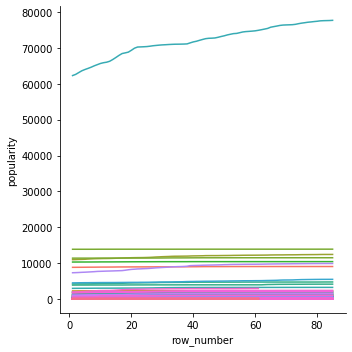

In [89]:
sns.relplot(data=natural_news,
            x='row_number', y='popularity',
            hue='url', kind='line',
            legend=False)